In [1]:
pwd

'C:\\Users\\Lenovo'

In [3]:
cd E:\\python35

E:\python35


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
#config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
#matplotlib inline


In [5]:
# Load train and Test set
train = pd.read_csv("train (1).csv")
test = pd.read_csv("test (1).csv")

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the 'Id' column since it's unnecessary for the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


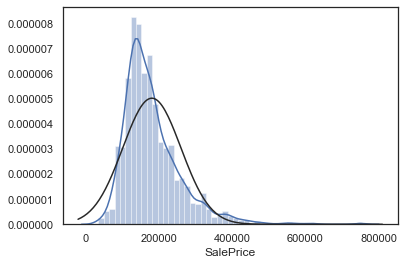

In [7]:
# Getting Description
train['SalePrice'].describe()



####################
# Plot Histogram
sns.distplot(train['SalePrice'] , fit=norm);




 mu = 180921.20 and sigma = 79415.29



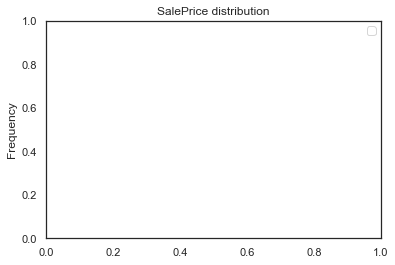

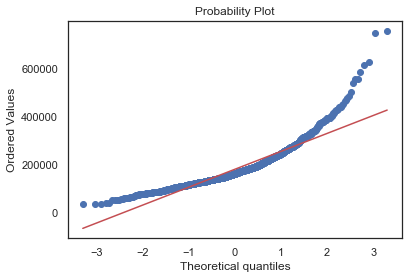

In [8]:
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


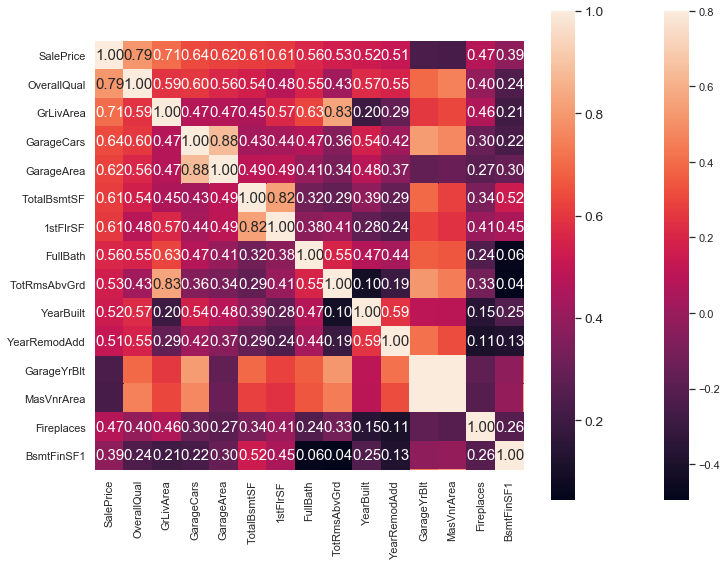

In [9]:
#################
# Correlation Matrix Heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);


################
# Top 15 Heatmap
k =15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


In [10]:
most_corr = pd.DataFrame(cols)
#most_corr.columns = ['Most Correlated Features']

columns = train.columns.tolist()

columns = [c for c in columns if c in cols]
train=train[columns]

columns1 = [c for c in columns if c in cols[1:]]

test=test[columns1]
train.head()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,SalePrice
0,7,2003,2003,196.0,706,856,856,1710,2,8,0,2003.0,2,548,208500
1,6,1976,1976,0.0,978,1262,1262,1262,2,6,1,1976.0,2,460,181500
2,7,2001,2002,162.0,486,920,920,1786,2,6,1,2001.0,2,608,223500
3,7,1915,1970,0.0,216,756,961,1717,1,7,1,1998.0,3,642,140000
4,8,2000,2000,350.0,655,1145,1145,2198,2,9,1,2000.0,3,836,250000


In [11]:
# Checking Categorical Data
train.select_dtypes(include=['object']).columns


################
# Checking Numerical Data
train.select_dtypes(include=['int64','float64']).columns

cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')


Total Features:  0 categorical + 15 numerical = 15 features


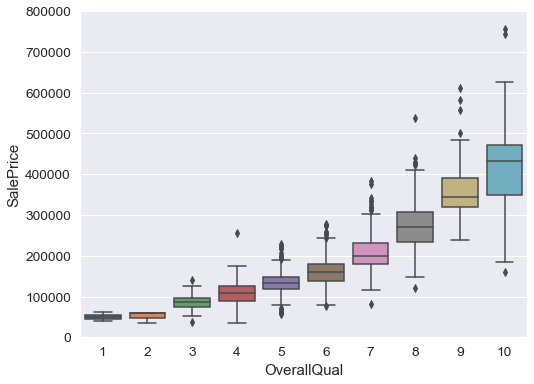

In [12]:

# Overall Quality vs Sale Price
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);


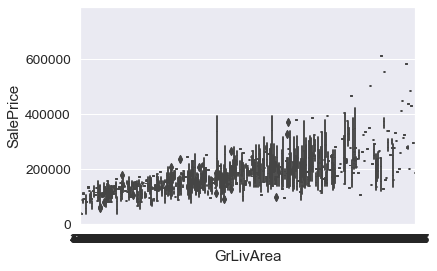

In [13]:

############
# Living Area vs Sale Price
sns.boxplot(x=train['GrLivArea'], y=train['SalePrice'])


##############
# Removing outliers manually (Two points in the bottom right)
train = train.drop(train[(train['GrLivArea']>4000) 
                         & (train['SalePrice']<250000)].index).reset_index(drop=True)


##############
# Living Area vs Sale Price
sns.boxplot(x=train['GrLivArea'], y=train['SalePrice'])


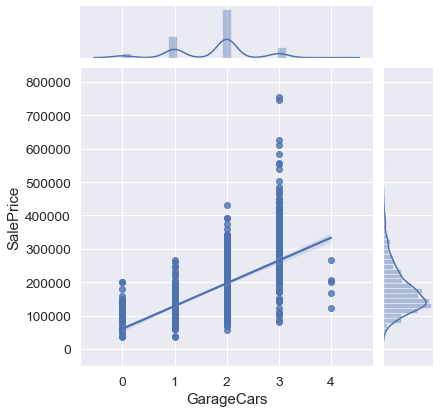

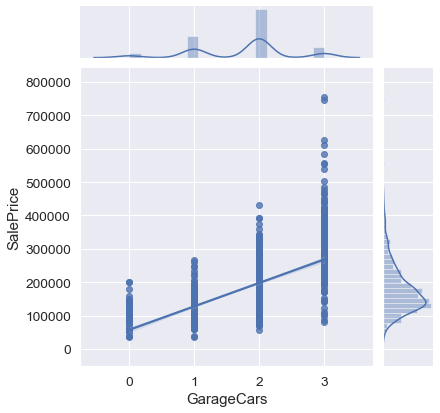

In [14]:

############
# Garage Area vs Sale Price
sns.jointplot(x=train['GarageCars'], y=train['SalePrice'],kind='reg')



#########
# Removing outliers manually (More than 4-cars, less than $300k)
train = train.drop(train[(train['GarageCars']>3) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)



#########
# Garage Area vs Sale Price
sns.jointplot(x=train['GarageCars'], y=train['SalePrice'],kind='reg')


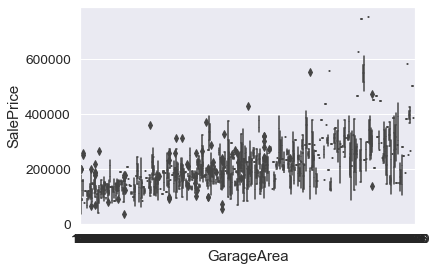

In [15]:
# Garage Area vs Sale Price
sns.boxplot(x=train['GarageArea'], y=train['SalePrice'])
plt.show()


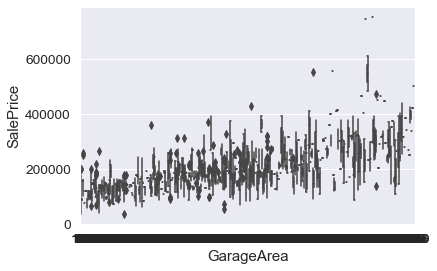

In [16]:
##########
# Removing outliers manually (More than 1000 sqft, less than $300k)
train = train.drop(train[(train['GarageArea']>900) 
                         & (train['SalePrice']<250000)].index).reset_index(drop=True)



##########
# Garage Area vs Sale Price
sns.boxplot(x=train['GarageArea'], y=train['SalePrice'])


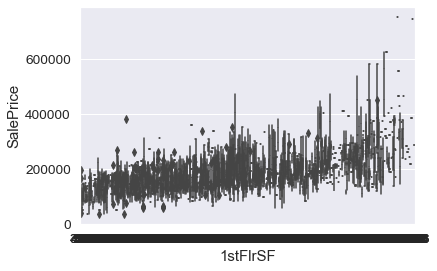

In [17]:
##########
# Basement Area vs Sale Price
sns.boxplot(x=train['TotalBsmtSF'], y=train['SalePrice'])



############
# First Floor Area vs Sale Price
sns.boxplot(x=train['1stFlrSF'], y=train['SalePrice'])



############
# Total Rooms vs Sale Price
#sns.boxplot(x=train['TotRmsAbvGrd'], y=train['SalePrice'])



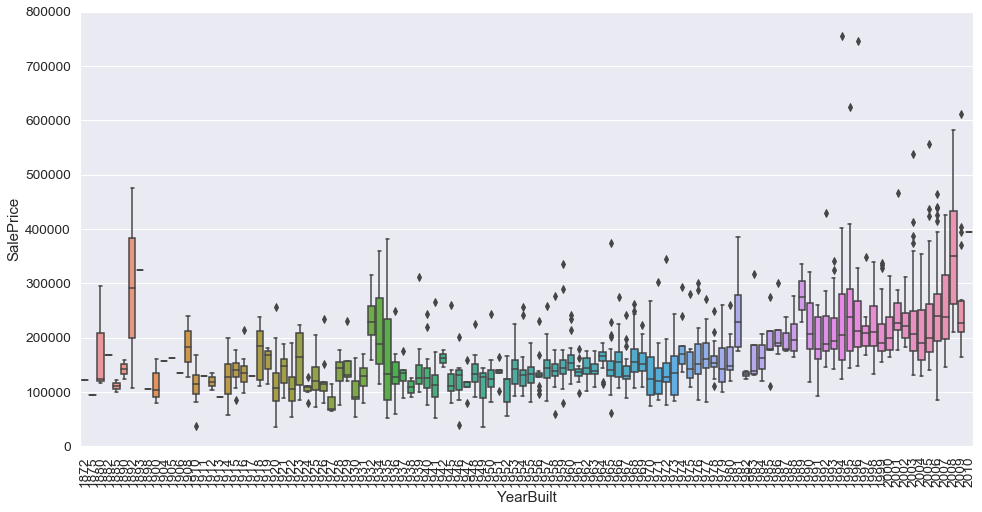

In [18]:
#############
# Total Rooms vs Sale Price
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);


In [19]:
##############
# Combining Datasets
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))


Train data size is : (1445, 15)
Test data size is : (1459, 14)
Combined dataset size is : (2904, 14)


In [20]:
all_data["Fireplaces"] = all_data["Fireplaces"].fillna(0)

for col in ( 'GarageArea', 'GarageCars', 'BsmtFinSF1','TotalBsmtSF','FullBath','1stFlrSF','OverallQual','GrLivArea','TotRmsAbvGrd','YearBuilt','FullBath','YearRemodAdd','GarageYrBlt'):
    all_data[col] = all_data[col].fillna(0)
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [21]:
# Adding Total Square Feet feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] 


In [22]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])



 mu = 12.02 and sigma = 0.40



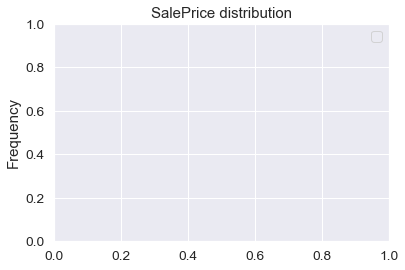

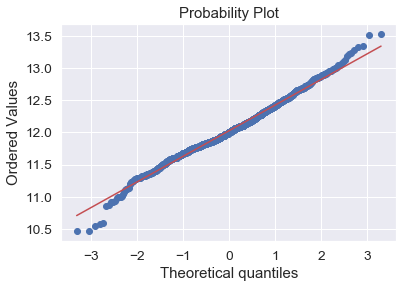

In [23]:
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


In [24]:
y_train = train.SalePrice.values



###################
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index



all_data = pd.get_dummies(all_data)
    

In [25]:
############
train = all_data[:ntrain]
test = all_data[ntrain:]

train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1445 entries, 0 to 1444
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1445 non-null   int64  
 1   YearBuilt     1445 non-null   int64  
 2   YearRemodAdd  1445 non-null   int64  
 3   MasVnrArea    1445 non-null   float64
 4   BsmtFinSF1    1445 non-null   float64
 5   TotalBsmtSF   1445 non-null   float64
 6   1stFlrSF      1445 non-null   int64  
 7   GrLivArea     1445 non-null   int64  
 8   FullBath      1445 non-null   int64  
 9   TotRmsAbvGrd  1445 non-null   int64  
 10  Fireplaces    1445 non-null   int64  
 11  GarageYrBlt   1445 non-null   float64
 12  GarageCars    1445 non-null   float64
 13  GarageArea    1445 non-null   float64
 14  TotalSF       1445 non-null   float64
dtypes: float64(7), int64(8)
memory usage: 169.5 KB


In [26]:
################
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb



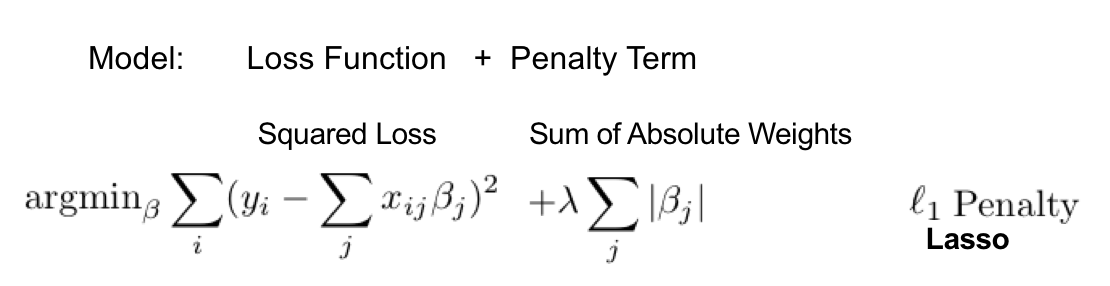

In [36]:
from IPython.display import Image
Image(filename='lasso.png')

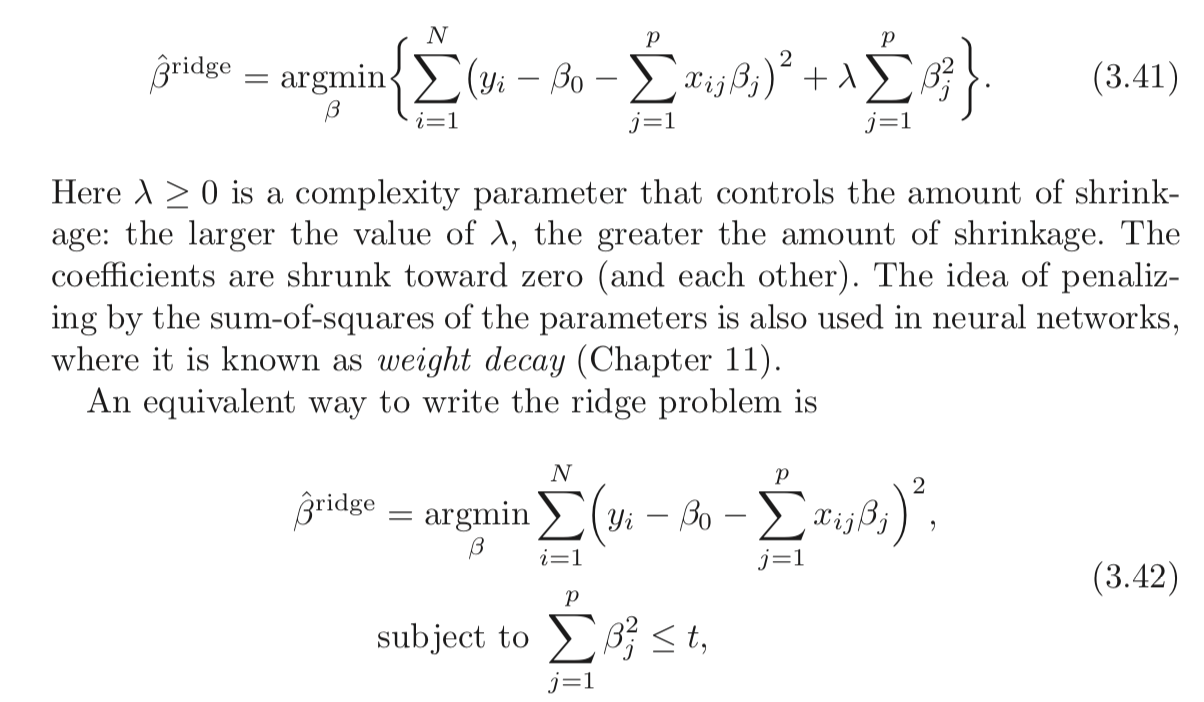

In [38]:
from IPython.display import Image
Image(filename='RID.png')

In [27]:

###############
# Cross-validation with k-folds
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)




#############
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)






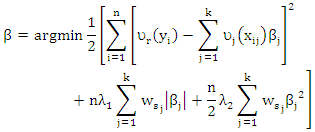

In [40]:
from IPython.display import Image
Image(filename='EL.png')

In [28]:

#############
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))







Lasso score: 0.1416 (0.0024)

ElasticNet score: 0.1416 (0.0024)

Kernel Ridge score: 0.1448 (0.0061)

Gradient Boosting score: 0.1473 (0.0083)

Xgboost score: 0.1455 (0.0039)

LGBM score: 0.1417 (0.0037)



In [29]:


#############
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 
    
    
    
###########
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))






Averaged base models score: 0.1374 (0.0033)



In [30]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):                       
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(clf)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
    
    
    
    
############
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))


 


Stacking Averaged models score: 0.1376 (0.0029)


In [31]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))



In [32]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

print(train.values)



0.11397313573066166
[[7.000e+00 2.003e+03 2.003e+03 ... 2.000e+00 5.480e+02 1.712e+03]
 [6.000e+00 1.976e+03 1.976e+03 ... 2.000e+00 4.600e+02 2.524e+03]
 [7.000e+00 2.001e+03 2.002e+03 ... 2.000e+00 6.080e+02 1.840e+03]
 ...
 [7.000e+00 1.941e+03 2.006e+03 ... 1.000e+00 2.520e+02 2.340e+03]
 [5.000e+00 1.950e+03 1.996e+03 ... 1.000e+00 2.400e+02 2.156e+03]
 [5.000e+00 1.965e+03 1.965e+03 ... 1.000e+00 2.760e+02 2.512e+03]]


In [33]:
##############
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))




#############
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))




0.07201433281023609
0.10689237054785283


In [34]:
#############
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.10 + lgb_train_pred*0.20 ))


RMSLE score on train data:
0.10616427050324757


In [35]:
############
# Example
Stacked = 1/(0.1077)
XGBoost = 1/(0.1177)
LGBM = 1/(0.1159)
Sum = Stacked + XGBoost + LGBM
Stacked = Stacked/Sum
XGBoost = XGBoost/Sum
LGBM = LGBM/Sum
print(Stacked, XGBoost, LGBM)


############
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*Stacked +
               xgb_train_pred*XGBoost + lgb_train_pred*LGBM))




###########
ensemble = stacked_pred*Stacked + xgb_pred*XGBoost + lgb_pred*LGBM


import pickle


pickle.dump(model_xgb, open('model_xgb.pkl','wb'))
model_xgb=pickle.load(open('model_xgb.pkl','rb'))



pickle.dump(model_lgb, open('model_lgb.pkl','wb'))
model_lgb=pickle.load(open('model_lgb.pkl','rb'))



pickle.dump(stacked_averaged_models, open('stacked_averaged_models.pkl','wb'))
stacked_averaged_models=pickle.load(open('stacked_averaged_models.pkl','rb'))


##########
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)


0.35158188821434966 0.32171086967447293 0.3267072421111774
RMSLE score on train data:
0.09488849608301633
